# Chapter 6. Kernel Smoothing Methods

In this chapter we describe a class of regression techniques that achieve flexibility in estimating the regression function $f(X)$ over the domain $\mathbb{R}^p$ by fitting a different but simple model separately at each query point $x_0$. This is done for some neighborhood of the target point $x_0$ to fit the simple model, and in such a way that the resulting estimated function $\hat{f}(X)$ is smooth in $\mathbb{R}^p$.

This localization is achieved via a weighting function or _kernel_ $K_\lambda(x_0,x_i)$, which assigns a weight to $x_i$ based on its distance from $x_0$. The kernels $K_\lambda$ are typically indexed by a paramter $\lambda$ that dictates the width of the neighborhood. These _memory-based_ methods require in principle little or no training. The only paramter that needs to be determined from the training data is $\lambda$. The model, however, is the entire training data set.

We also discuss more general classes of kernel-based techniques, which tie in with structured methods in other chapters, and are useful for density estimation and classficiation.

### Caution, don't confuse!

> In this chapter kernels are mostly used as a device for localization.

The techniques in this chapter should not be confused with those associated with the more recent usage of the phrase "kernel methods". In this chapter kernels are mostly used as a device for localization. We discuss kernel methods in $\S$ 5.8, 14.5.4, 18.5, and Chapter 12; in those contexts the kernel computes an inner product in a high-dimensional (implicit) feature space, and is used for regularized nonlinear modeling. We make some connections to the methodology in this chapter at the end of $\S$ 6.7.

# $\S$ 6.1. One-Dimensional Kernel Smoothers

In Chapter 2, we motivated the $k$-nearest-neighbor average

\begin{equation}
\hat{f}(x) = \text{Ave}\left( y_i|x_i\in N_k(x) \right)
\end{equation}

as an estimate of the regression function $\text{E}(Y|X=x)$. The idea is to relax the definition of conditional expectation, as illustrated in the left panel of FIGURE 6.1, and compute an average in a neighborhood of the target point.

The KNN average changes in a discrete way, leading to a discontinuous $\hat{f}$, which is ugly and unnecessary.

In [1]:
%matplotlib inline
import scipy
import matplotlib.pyplot as plt

# K-nearest neighbors (Section 2.3)
def knn(k: int, point:float,
        data_x:scipy.ndarray, data_y:scipy.ndarray) -> float:
    idx_sorted = scipy.argsort((data_x-point)*(data_x-point))[:k]
    return data_y[idx_sorted].mean()

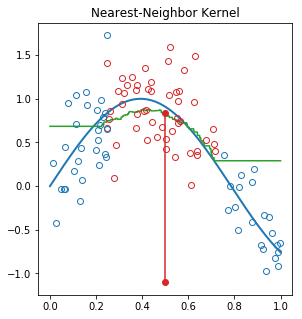

In [23]:
"""FIGURE 6.1. (The left panel) The result of 30-NN running-mean smoother
The green curve is bumpy, since the 30-NN average is discontinuous."""
xgrid = scipy.linspace(0, 1, 1001)
y_true = scipy.sin(4*xgrid)

size_sample = 100
x_sample = scipy.random.uniform(size=size_sample)
y_sample = scipy.sin(4*x_sample) + scipy.randn(size_sample)/3

idx_x0 = 500
x0 = xgrid[idx_x0]  # .5
idx_x0_neighbors = scipy.argsort((x_sample-x0)*(x_sample-x0))

k = 50
y_knn = scipy.array([knn(k, x, x_sample, y_sample) for x in xgrid])

fig61 = plt.figure(61, figsize=(10, 5))
ax1 = fig61.add_subplot(1, 2, 1)
ax1.plot(xgrid, y_true, color='C0', linewidth=2)
ax1.plot(xgrid, y_knn, color='C2')
ax1.plot(x_sample[idx_x0_neighbors[:k]], y_sample[idx_x0_neighbors[:k]],
         'o', color='C3', mfc='none')
ax1.plot(x_sample[idx_x0_neighbors[k:]], y_sample[idx_x0_neighbors[k:]],
         'o', color='C0', mfc='none')
ax1.plot((x0, x0), (ax1.get_ylim()[0], y_knn[idx_x0]), 'o-', color='C3')
ax1.set_title('Nearest-Neighbor Kernel')
plt.show()

### Kernel-weighted average

> Rather than give all the points in the neighborhood equal weight, we can assign weights that die off smoothly with distance from the target point.

The right panel shows an example of this, using the so-called Nadaraya-Watson kernel-weighted average

\begin{equation}
\hat{f}(x_0) = \frac{\sum_{i=1}^N K_\lambda(x_0, x_i)y_i}{\sum_{i=1}^N K_\lambda(x_0, x_i)},
\end{equation}

with the _Epanechnikov_ quadratic kernel

\begin{equation}
K_\lambda(x_0,x) = D \left( \frac{|x-x_0|}\lambda \right),
\end{equation}

with

\begin{equation}
D(t) = \begin{cases}
\frac34 (1-t^2) & \text{if } |t| \le 1; \\
0 & \text{otherwise}.
\end{cases}
\end{equation}

In [38]:
"""FIGURE 6.1. (The right panel) The kernel-weighted average using an Epanechnikov kernel
with (half) window width lambda=0.2."""
def Epanechnikov(lmbda:float, point:float,
                 data_x:scipy.ndarray, data_y:scipy.ndarray) -> float:
    t = scipy.absolute(data_x-point)/lmbda  # argment for D
    k = scipy.where(t <= 1, 0.75*(1-t), 0)
    return (k @ data_y).sum()/k.sum()

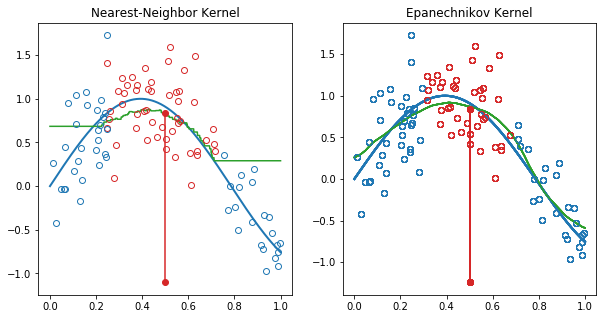

In [39]:
lmbda = .2
y_knn_weighted = scipy.array([Epanechnikov(lmbda, x, x_sample, y_sample)
                              for x in xgrid])

mask_neighbor = scipy.absolute(x_sample-x0)/lmbda <= 1

ax2 = fig61.add_subplot(1, 2, 2)
ax2.plot(xgrid, y_true, color='C0', linewidth=2)
ax2.plot(xgrid, y_knn_weighted, color='C2')
ax2.plot(x_sample[~mask_neighbor], y_sample[~mask_neighbor], 'o', color='C0', mfc='none')
ax2.plot(x_sample[mask_neighbor], y_sample[mask_neighbor],
         'o', color='C3', mfc='none')
ax2.plot((x0, x0), (ax1.get_ylim()[0], y_knn[idx_x0]), 'o-', color='C3')
ax2.set_title('Epanechnikov Kernel')
fig61

The fitted function is now continuous, and quite smooth in the right panel. As we move the target from left to right, points enter the neighborhood initially with weight zero, and then their contribution slowly increases (see Exercise 6.1).

Note that we used a metric window size $\lambda=0.2$ for the kernel fit, which does not change as we move the target point $x_0$, while the size of the 30-NN smoothing window adapts to the local density of the $x_i$. One can, however, also use such adaptive neighborhoods with kernels, but we need to use a more general notation.

\begin{equation}
K_\lambda(x_0, x) = D \left( \frac{|x-x_0|}{h_\lambda(x_0)} \right),
\end{equation}

where $h_\lambda(x_0)$ is a width function (indexed by $\lambda$) that determines the width of the neighborhood at $x_0$.

* The Epanechnikov kernel uses a constant $h_\lambda(x_0)=\lambda$.
* KNN replaces $\lambda$ with the neighborhood size $k$, and we have

  \begin{equation}
  h_k(x_0) = |x_0 - x_{[k]}|,
  \end{equation}
  
  where $x_{[k]}$ is the $k$th closest $x_i$ to $x_0$.

### Some implications

* The smoothing parameter $\lambda$, which determines the width of the local neighborhood, has to be determined.
  * Large $\lambda$ implies lower variance -- averages over more observations,  
  * but higher bias -- we essentially assume the true functionis constant within the window.

* Metric window widths (constant $h_\lambda(x)$) tend to keep the bias of the estimate constant, but the variance is inversely proportional to the local density.  
  Nearest-neighbor window width exhibit the oppoite behavior; the variance stays constant and the absolute bias varies inversely with local density.

* Issues arise with nearest-neighbors when there are ties in the $x$. With most smoothing techniques one can simply reduce the data set by averaging the $y_i$ at tied values of $X$, and supplementing these new observations at the unique values of $x_i$ with an additional weight $w_i$ (which multiples the kernel weight).

* This leaves a more general problem to deal with: Observation wieghts $w_i$.  
  Operationally we simply multiply them by the kernel weights before computing the weighted average. With nearest neighborhoods, it is now natural to insist on neighborhoods with a total weight content $k$ (relative to $\sum w_i$).  
  In the event of overflow (the last observation needed in a neighborhood has a weight $w_j$, which causes the sum of weights to exceed the budget $k$), then fractional parts can be used.

* Boundary issues arise. The metric neighborhoods tend to contain less points on the boundaries, while the nearest-neighborhoods get wider.

* The Epanechnikov kernel has compact support (needed when used with nearest-neighbor window size). Another popular compact kernel is based on the tri-cube function

  \begin{equation}
  D(t) = \begin{cases}
  (1-|t|^3)^3 & \text{ if } |t| \le 1;\\
  0 & \text{otherwise}.
  \end{cases}
  \end{equation}
  
  This is
  * flatter on top (like the nearest-neighbor box) and
  * differentiable at the boundary of its support.
  
  The Gaussian density function $D(t) = \phi(t)$ is a popular noncompact kernel, with standard deviation playing the role of the window size. See FIGURE 6.2 in the textbook.

## $\S$ 6.1.1. Local Linear Regression

The smooth kernel fit still has a problems. Locally-weighted averages can be badly biased on the boundaries of the domain, because of the asymmetry of the kernel in that region, as exhibited in FIGURE 6.3 (left panel).

By fitting straight lines rather than constants locally, we can remove this bias exactly to first order; see the right panel of FIGURE 6.3. Actually, this bias can be present in the interior of the domain as well, if the $X$ values are not equally spaced (for the same reasons, but usually less severe). Again locally weighted linear regression will make a first-order correction.

### Formulation

Locally weighted regression solves a separate weighted least squares problem at each target point $x_0$:

\begin{equation}
\min_{\alpha(x_0),\beta(x_0)} \sum_{i=1}^N K_\lambda(x_0,x_i) \left( y_i - \alpha(x_0) - \beta(x_0)x_i \right)^2.
\end{equation}

The estimate is then

\begin{equation}
\hat{f}(x_0) = \hat\alpha(x_0) + \hat\beta(x_0).
\end{equation}

Notice that although we fit an entire linear model to the data in the region, we only use it to evaluate the fit at the single point $x_0$.

### Matrix formulation and equivalent kernel

Define
* the vector-valued function $b(x)^T = (1, x)$,
* the $N\times2$ regression matrix $\mathbf{B}$ with $i$th row $b(x_i)^T$, and
* the $N\times N$ diagonal matrix $\mathbf{W}(x_0)$ with $i$th diagonal element $K_\lambda(x_0,x_i)$.

Then

\begin{align}
\hat{f}(x_0) &= b(x_0)^T \left( \mathbf{B}^T\mathbf{W}(x_0)\mathbf{B} \right)^{-1} \mathbf{B}^T \mathbf{W}(x_0) \mathbf{y} \\
&= \sum_{i=1}^N l_i(x_0)y_i.
\end{align}

Note that $l_i(x_0)$ do not involve $\mathbf{y}$ and thus the estimate is _linear_ in $y_i$. These weights $l_i(x_0)$ combine the weighting kernel $K_\lambda(x_0,\cdot)$ and the least squares operations, and are sometimes referred to as the _equivalent kernel_.

FIGURE 6.4 illustrates the effect of local linear regression on the equivalent kernel.

In [1]:
"""FIGURE 6.4. Equivalent kernel li(x0) for local regression"""
print('Under construction ...')

Under construction ...


### Automatic kernel carpentry

Historically, the bias in the Nadaraya-Watson and other local average kernel methods were corrected by modifying the kernel. These modifications were based on theoretical asymptotic MSE considerations, and besides being tedious to implement, are only approximate for finite sample sizes.

Local linear regression _automatically_ modfies the kernel to correct the bias _exactly_ to first order, a phenomenon dubbed as _automatic kernel carpentry_.

Consider the following expansion for $\text{E}\hat{f}(x_0)$, using the linearity of local regression and a series expansion of the true function $f$ around $x_0$,

\begin{align}
\text{E}\hat{f}(x_0) &= \sum_{i=1}^N l_i(x_0)f(x_i) \\
&= f(x_0)\sum_{i=1}^N l_i(x_0) + f'(x_0)\sum_{i=1}^N (x_i-x_0)l_i(x_0) + \frac{f''(x_0)}2 \sum_{i=1}^N \sum_{i=1}^N (x_i-x_0)^2 l_i(x_0) + R,
\end{align}

where the remainder term $R$ involves third- and higher-order derivatives of $f$, and is typically small under suitable smoothness assumptions. It can be shown (Exercise 6.2) that for local linear regression,

\begin{equation}
\sum_{i=1}^N l_i(x_0) = 1 \text{ and } \sum_{i=1}^N (x_i-x_0)l_i(x_0) = 0.
\end{equation}

Hence

\begin{align}
\text{E}\hat{f}(x_0) &= f(x_0)\sum_{i=1}^N l_i(x_0) + f'(x_0)\sum_{i=1}^N (x_i-x_0)l_i(x_0) + \frac{f''(x_0)}2 \sum_{i=1}^N \sum_{i=1}^N (x_i-x_0)^2 l_i(x_0) + R \\
&= f(x_0) + \frac{f''(x_0)}2 \sum_{i=1}^N \sum_{i=1}^N (x_i-x_0)^2 l_i(x_0) + R,
\end{align}

and the bias

\begin{equation}
\text{E}\hat{f}(x_0) - f(x_0) = \frac{f''(x_0)}2 \sum_{i=1}^N \sum_{i=1}^N (x_i-x_0)^2 l_i(x_0) + R.
\end{equation}

We see that it depends only on quadratic and higher-order terms in the expansion of $f$.

## $\S$ 6.1.2. Local Polynomial Regression

Why stop at local linear fit? We can fit local polynomial fits of any degree $d$,

\begin{equation}
\min_{\alpha(x_0),\beta_j(x_0), j=1,\cdots,d} \sum_{i=1}^N K_\lambda(x_0,x_i) \left( y_i - \alpha(x_0) - \sum_{j=1}^d \beta_j(x_0)x_i^j \right)^2
\end{equation}

with solution

\begin{equation}
\hat{f}(x_0) = \hat\alpha(x_0) + \sum_{j=1}^N \hat\beta(x_0)x_o^j.
\end{equation}

In fact, the expansion shown in the previous section will tell us that the bias will only have components of degree $d+1$ and higher (Exercise 6.2).

FIGURE 6.5 illustrates local quadratic regression. Local linear fits tend to be biased in regions of curvature of the true function, a phenomenon referred to as _trimming the hills_ and _filling the valleys_. Local quadratic regression is generally able to correct this bias.

### Bias-variance tradeoff, again

There is of course a price to be paid for this bias reduction, and this is increased variance. The fit in the right panel of FIGURE 6.5 is slightly more wiggly, especially in the tails.

Assume the model

\begin{equation}
y_i = f(x_i) + \epsilon_i,
\end{equation}

with $\epsilon_i \sim^{\text{iid}} (0, \sigma^2)$. Then

\begin{equation}
\text{Var}(\hat{f}(x_0)) = \sigma^2 \|l(x_0)\|^2,
\end{equation}

where $l(x_0)$ is the vector of equivalent kernel weights at $x_0$.

It can be shown (Exercise 6.3) that $\|l(x_0)\|$ increases with $d$, and so there is a bias-variance tradeoff in selecting the polynomial degree.

FIGURE 6.6 illustrates these variance curves for degree zero, one and two local polynomials. To summarize some collected wisdom on this issue:

* Local linear fits can help bias dramatically at the boundaries at a modest cost in variance. Local quadratic fits do little at the boundaries for bias, but increase the variance a lot.
* Local quadratic fits tend to be most helpful in reducing bias due to curvature in the interior of the domain.
* Asymptotic analysis suggest that local polynomials of odd degree dominate those of even degree. This is largely due to the fact that asymptotically the MSE is dominated by boundary effects.

While it may be helpful to tinker, and move from local linear fits at the boundary to local quadratic fits in the interior, we do not recommend such strategies. Usually the application will dictate the degree of the fit. For example, if we are interested in extrapolation, then the boundary is of more interest and local linear fits are probably more reliable.

# $\S$ 6.2. Selecting the Width of the Kernel

In each of the kernels $K_\lambda$, $\lambda$ is a parameter that controls its width:

* For the Epanechnikov or tri-cube kernel with metric width, $\lambda$ is the radius of the support region.
* For the Gaussian kernel, $\lambda$ is the standard deviation.
* $\lambda$ is the number $k$ of nearest neighbors in $k$-nearest neighborhoods, often expressed as a fraction or _span_ $k/N$ of the total training sample.

### Bias-variance tradeoff, again and again

There is a natural bias-variance tradeoff as we change the width of the averaging window, which is most explicit for local averages:

* If the window is narrow, $\hat{f}(x_0)$ is an average of a small number of $y_i$ close to $x_0$, and its variance will be relatively large -- close to that of an individual $y_i$. The bias will tend to be small, again because each of the $\text{E}(y_i) = f(x_i)$ should be close to $f(x_0)$.
* If the window is wide, the variance of $\hat{f}(x_0)$ will be small relative to the variance of any $y_i$, because of the effects of averaging. The bias will be higher, because we are now using observations $x_i$ further from $x_0$, and there is no quarantee that $f(x_i)$ will be close to $f(x_0)$.

Similar arguments apply to local regression estimates, say local linear:
* As the width goes to zero, the estimates approach a piecewise-linear function that interpolates the training data;
* as the width gets infinitely large, the fit approaches the global linear least-squares fit to the data.

The discussion in Chapter 5 on selecting the regularization parameter for smoothing splines applies here, and will not be repeated.

Local regression smoothers are linear estimators; the smoother matrix in

\begin{equation}
\hat{\mathbf{f}} = \mathbf{S}_\lambda\mathbf{y}
\end{equation}

is built up from the equivalent kernels ($\S$ 6.1.1), and has $ij$th entry $\{\mathbf{S}_\lambda\}_{ij} = l_i(x_j)$.

Leave-one-out cross-validation is particularly simple (Exercise 6.7), as is generalized cross-validation, $C_p$ (Exercise 6.10), and $k$-fold cross-validation. The effective degrees of freedom is again defined as $\text{trace}(\mathbf{S}_\lambda)$, and can be used to calibrate the amount of smoothing.

FIGURE 6.7 compares the equivalent kernels for a smoothing spline and local linear regression. The local regression smoother has a span of $40%$, which results in $\text{df} = \text{trace}(\mathbf{S}_\lambda) = 5.86$. The smoothing spline was calibrated to have the same $\text{df}$, and their equivalent kernels are qualitatively quite similar.

In [1]:
"""FIGURE 6.7. Equivalent kernels for a local linear regreession smoother and
a smoothing spline"""
print('Under construction ...')

Under construction ...


# $\S$ 6.3. Local Regression in $\mathbb{R}^p$

Kernel smoothing and local regression generalize very naturally to two or more dimensions.

* The Nadaraya-Watson kernel smoother fits a constant locally with weights supplied by a $p$-dimensional kernel.
* Local linear regression will fit a hyperplane locally in $X$, by weighted least squares, with weights supplied by a $p$-dimensional kernel.  
  It is simple to implement and is generally preferred to the local constant fit for its superior performacne on the boundaries.

### Formulation

Let $b(X)$ be a vector of polynomial terms in $X$ of maximum degree $d$; e.g., with $d=1$ and $p=2$ we get

\begin{equation}
b(X) = (1, X_1, X_2);
\end{equation}

with $d=2$ we get

\begin{equation}
b(X) = (1, X_1, X_2, X_1^2, X_2^2, X_1X_2);
\end{equation}

and trivially with $d=0$ we get

\begin{equation}
b(X) = 1.
\end{equation}

At each $x_0 \in \mathbb{R}^p$ solve

\begin{equation}
\min_{\beta(x_0)} \sum_{i=1}^N K_\lambda(x_0,x_i) \left( y_i - b(x_i)^T\beta(x_0) \right)^2
\end{equation}

to produce the fit

\begin{equation}
\hat{f}(x_0) = b(x_0)^T \hat\beta(x_0).
\end{equation}

Typically the kernel will be a radial function, such as the radial Epanechnikov or tri-cube kernel

\begin{equation}
K_\lambda(x_0,x) = D\left( \frac{\|x-x_0\|}\lambda \right),
\end{equation}

where $\|\cdot\|$ is the Euclidean norm.

Since the Euclidean norm depends on the units in each coordinate, it makes most sense to standardize each predictor, e.g., to unit standard deviation, prior to smoothing.

### Boundary problem gets serious with the curse of dimensionality

While boundary effects are a problem in 1D smoothing, they are a much bigger problem in two or higher dimensions, since the fraction of points on the boundary is larger. In fact, one of the manifestations of the curse of dimensionality is that the fraction of points close to the boundary increases to one as the dimension grows.

Directly modifying the kernel to accommodate two-dimensional boundaries becomes very messy, especially for irregular boundaries.

Local polynomial regression seamlessly performs boundary correction to the desired order in any dimensions. FIGURE 6.8 illustrates local linear regression on some measurements from an astronomical study with an unusual predictor design (star-shaped). Here the boundary is extremely irregular, and the fitted surface must also interpolate over regions of increasing data sparsity as we approach the boundary.

In [1]:
"""FIGURE 6.8 3D Galaxy data"""
print('Under construction ...')

Under construction ...


Local regression becomes less useful in dimensions much higher than two or three. We have discussed in some detail the problems of the dimensionality, e.g., in Chapter 2. It is impossible to simultaneously maintain localness ($\Rightarrow$ low bias) and a sizeable sample in the neighborhood ($\Rightarrow$ low variance) as the dimension increases, without the total sample size increasing exponentially in $p$.

Visualization of $\hat{f}(X)$ also becomes difficult in higher dimensions, and this is often one of the primary goals of smoothing. Although the scatter-cloud and wire-frame pictures in FIGURE 6.8 look at attractive, it is quite difficult to interpret the results except at a gross level.

From a data analysis perspective, conditional plots are far more useful.

FIGURE 6.9 shows an analysis of some environmental data with three predictors. The _trellis_ display here show ozone as a function of radiation, conditioned on the other two variables, temperature and wind speed. However, conditioning on the value of a variable really implies loca to that value (as in local regression).

In [2]:
"""FIGURE 6.9. Conditional plots for Los Angeles Ozone data"""
print('Under construction ...')

Under construction ...


Above each of the panels in FIGURE 6.9 is an indication of the range of values present in that panel for each of the conditioning values. In the panel itself the data subsets are displayed (response versus remaining variable), and a 1D local linear regression is fit to the data.

Although this is not quite the same as looking at slices of a fitted 3D surface, it is probably more useful in terms of understanding the joint behavior of the data.

# $\S$ 6.4. Structured Local Regression Models in $\mathbb{R}^p$

> When the dimension to sample-size ratio is unfavorable, local regression does not help us much, unless we are willing to make some structural assumptions about the model.
>
> Much of this book is about structured regression and classification models. Here we focus on some approaches directly related to kernel methods.

## $\S$ 6.4.1. Structured Kernels
### Standardization

One line of approach is to modify the kernel. The default spherical kernel

\begin{equation}
K_\lambda(x_0,x) = D\left( \frac{\|x-x_0\|}\lambda \right)
\end{equation}

gives equal weight to each coordinate, and so a natural default strategy is to standardize each variable to unit standard deviation.

A more general approach is to use a positive semidefinite matrix $\mathbf{A}$ to weigh the different coordinates:

\begin{equation}
K_{\lambda,\mathbf{A}}(x_0,x) = D \left( \frac{(x-x_0)^T\mathbf{A}(x-x_0)}\lambda \right).
\end{equation}

Entire coordinates or directions can be downgraded or omitted by imposing appropriate restrictions on $\mathbf{A}$. For example, if $\mathbf{A}$ is diagonal, then we can increase or decrease the influence of individual predictors $X_j$ by increasing or decreasing $A_{jj}$.

Often the predictors are many and highly correlated, such as those arising from digitized analog signals or images. The covariance function of the predictors can be used to tailor a metric $\mathbf{A}$ that focuses less, say, on high-freqeuncy contrast (Exercise 6.4).

### Structured regression over general models for $\mathbf{A}$

Proposals have been made for learning the parameters for multidimensional kernels. For example, the projection-pursuit regression model discussed in Chapter 11 is of this flavor, where low-rank versions of $\mathbf{A}$ imply ridge functions for $\hat{f}(X)$.

More general models for $\mathbf{A}$ are cumbersome, and we favor instead the structured forms for the regression function discussed next.

## $\S$ 6.4.2. Structured Regression Functions

We are trying to fit a regression function

\begin{equation}
\text{E}(Y|X) = f(X_1,X_2,\cdots,X_p)
\end{equation}

in $\mathbb{R}^p$, in which every level of interaction is potentially present.

### Structure via ANOVA decomposition
It is natural to consider ANOVA decompositions of the form

\begin{equation}
f(X_1,X_2,\cdots,X_p) = \alpha + \sum_j g_j(X_j) + \sum_{k<l} g_{kl}(X_k,X_l) + \cdots
\end{equation}

and then introduce structure by eliminating some of the higher-order terms.

Additive models assume only main effect terms:

\begin{equation}
f(X) = \alpha + \sum_{j=1}^p g_j(X_j);
\end{equation}

Second-order models will have terms with interactions of order at most two, and so on.

### Backfitting
In Chapter 9, we describe iterative _backfitting_ algorithms for fitting such lower-order interaction models. In the additive model, for example, if all but the $k$th term is assumed known, then we can estimate $g_k$ by local regression of $Y - \sum_{j\neq k}g_j(X_j)$ on $X_k$. This is done for each function in turn, repeatedly, until convergence. The important detail is that at any stage, 1D local regression is all that is needed. The same ideas can be used to fit low-dimensional ANOVA decompositions.

### Varying coefficients models
An important special case of these structured models are the class ofr _varying coefficient models_. Suppose that we divide the $p$ predictors in $X$ into a set $(X_1, X_2, \cdots, X_q)$ with $q<p$, and the remainder of the variables we collect in the vector $Z$. We then assume the conditionally linear model

\begin{equation}
f(X) = \alpha(Z) + \beta_1(Z)X_1 + \cdots + \beta_q(Z)X_q.
\end{equation}

For given $Z$, this is a linear model, but each of the coefficients can vary with $Z$. It is natural to fit such a model by locally weighted least squares:

\begin{equation}
\min_{\alpha(z_0),\beta(z_0)} \sum_{i=1}^N K_\lambda(z_0,z_i) \left( y_i - \alpha(z_0) - x_{i1}\beta_1(z_0) - \cdots - x_{qi}\beta_q(z_0) \right)^2
\end{equation}

FIGURE 6.10 illustrates the idea on measurements of the human aorta. A longstanding claim has been that the aorta thickens with $\textsf{age}$. Here we model the $\textsf{diameter}$ of the aorta as a linear function of $\textsf{age}$, but allow the coefficients to vary with $\textsf{gender}$ and $\textsf{depth}$ down the aorta. We used a local regression model separately for males and females. Wile aorta clearly does thicken with age at the higher regions of the aorta, the relationship fades with distance down the aorta. FIGURE 6.11 shows the intercept and slope as a function of depth.

In [1]:
"""FIGURE 6.10 and 6.11"""
print('IDK whether I have this data...')

IDK whether I have this data...


# $\S$ 6.5. Local Likelihood and Other Models

The concept of local regression and varying coefficient models is extremely broad: Any parametric model can be made local if the fitting method accommodates observation weights. Here are some examples:

1.

Associated with each observation $y_i$ is a parameter

\begin{equation}
\theta_i = \theta(x_i) = x_i^T\beta
\end{equation}

linear in the covariate(s) $x_i$, and inference for $\beta$ is based on the log-likelihood

\begin{equation}
l(\beta) = \sum_{i=1}^N l(y_i,x_i^T\beta).
\end{equation}

We can model $\theta(X)$ more flexibly by using the likelihood local to $x_0$ for inference of $\theta(x_0) = x_0^T\beta(x_0)$:

\begin{equation}
l(\beta(x_0)) = \sum_{i=1}^N K_\lambda(x_0,x_i) l(y_i,x_i^T\beta(x_0)).
\end{equation}

Many likelihood models, in particular the family of  generalized linear models including logistic and log-linear models, involve the covariates in a linear fashion. Local likelihood allows a relaxation from a globally linear model to one that is locally linear.

2.

As above, except different variables are associated with $\theta$ from those used for defining the local likelihood:

\begin{equation}
l(\theta(z_0)) = \sum_{i=1}^N K_\lambda(z_0,z_i) l\left(y_i,\eta(x_i,\theta(z_0))\right).
\end{equation}

For example, $\eta(x,\theta) = x^T\theta$ could be a linear model in $x$. This will fit a varying coefficient model $\theta(z)$ by maximizing the local likelihood.

3.

Autoregressive time series models of order $k$ have the form

\begin{equation}
y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + \cdots + \beta_k y_{t-k} + \epsilon_t.
\end{equation}

Denoting the _lag set_ by

\begin{equation}
z_t = (y_{t-1}, y_{t-2}, \cdots, y_{t-k}),
\end{equation}

the model looks like a standard linear model

\begin{equation}
y_t = z_t^T\beta + \epsilon,
\end{equation}

and is typically fit by least squares. Fitting by local least squares with a kernel $K(z_0,z_t)$ allows the model to vary according to the short-term history of the series.

This is to be distinguished from the more traditional dynamic linear models that vary by windowing time.

As an illustration of local likelihood, we consider the local version of the multiclass linear logistic regression model of Chapter 4. The data consist of features $x_i$ and an associated categorical response $g_i \in \{1,2,\cdots,J\}$, and the linear model has the form

\begin{equation}
\text{Pr}(G=j|X=x) = \frac{\exp\left(\beta_{j0} + \beta_j^Tx\right)}{1 + \sum_{k=1}^{J-1} \exp\left(\beta_{k0} + \beta_k^Tx\right)}.
\end{equation}

The local log-likelihood for this $J$ class model can be written

\begin{equation}
\sum_{i=1}^N K_\lambda(x_0,x_i) \left\{ \beta_{g_i 0}(x_0) + \beta_{g_i}^T(x_i-x_0) - \log\left( 1 + \sum_{k=1}^{J-1} \exp\left( \beta_{k0}(x_0) + \beta_k(x_0)^T(x_i-x_0) \right) \right) \right\}.
\end{equation}

Notice that
* we have used $g_i$ as a subscript in the first line to pick out the appropriate numerator;
* $\beta_{J0} = 0$ and $\beta_J = 0$ by the definition of the model;
* we have centered the local regressions at $x_0$, so that the fitted posterior probabilities at $x_0$ are simply  

  \begin{equation}
  \hat{\text{Pr}}(G=j|X=x) = \frac{\exp\left(\hat\beta_{j0} + \hat\beta_j^Tx\right)}{1 + \sum_{k=1}^{J-1} \exp\left(\hat\beta_{k0} + \hat\beta_k^Tx\right)}.
  \end{equation}
  
This model can be used for flexible multiclass classification in moderately low dimensions, although successes have been reported with the high-dimensional ZIP-code classficiation problem. Generalized additive models (Chapter 9) using kernel smoothing methods are closely related, and avoid dimensionality problems by assuming an additive structure for the regression function.

### Heart disease data, again

As a simple illustration we fit a two-class local linear logistic model to the heart disease data of Chapter 4. FIGURE 6.12 shows the univariate local logistic models fit to two of the risk factors (separately). This is a useful screening device for detecting nonlinearities, when the data themselves have little visual information to offer. In this case an unexpected anomaly is uncovered in the data, which may have gone unnoticed with traditional method.

In [1]:
"""FIGURE 6.12. Local logistic models for the heart disease data"""
print('Under construction ...')

Under construction ...


Since $\textsf{CHD}$ is a binary indicator, we could estimate the conditional prevalence $\text{Pr}(G=j|x_0)$ by simply smoothing this binary response directly without resorting to a likelihood formulation. This amounts to fitting a locally constant logistic regression model (Exercise 6.5). In order to enjoy the bias-correction of local-linear smoothing, it is more natural to operate on the unstricted logit scale.

Typically with logistic regression, we compute parameter estimates as well as their standard errors. This can be done locally as well, and so we can produce, as shown in the plot, estimated pointwise standard-error bands about our fitted prevalence.

# $\S$ 6.6. Kernel Density Estimation and Classification

Kernel density estimation is an unsupervised learning procedure, which historically precredes kernel regression. It also leads to naturally to a simple family of procedures for nonparametric classification.

## $\S$ 6.6.1. Kernel Density Estimation

### Density estimation

> Suppose we have a random sample $x_1,\cdots,x_N$ drawn from a probability density $f_X(x)$, and we wish to estimate $f_X$ at a point $x_0$.

For simplicity assume for now that $X\in\mathbb{R}$.

### Local estimate

A natural local estimate has the form

\begin{equation}
\hat{f}_X(x_0) = \frac{\#x_i \in \mathcal{N}(x_0)}{N\lambda},
\end{equation}

where $\mathcal{N}$ is a small metric neighborhood around $x_0$ of width $\lambda$.

This estimate is bumpy, so...

### Estimate with kernels

the smooth _Parzen_ estimate is preferred.

\begin{equation}
\hat{f}(x_0) = \frac1{N\lambda} \sum_{i=1}^N K_\lambda(x_0,x_i),
\end{equation}

because it counts observations close to $x_0$ with weights that decrease with distance from $x_0$. In this case a popular choice for $K_\lambda$ is the Gaussian kernel

\begin{equation}
K_\lambda(x_0,x) = \phi\left(\frac{|x-x_0|}\lambda\right).
\end{equation}

FIGURE 6.13 shows a Gaussian kernel density fit to the sample values for $\textsf{systolic blood pressure}$ for the $\textsf{CHD}$ group.

Letting $\phi_\lambda$ denote the Gaussian density with mean zero and standard-deviation $\lambda$, the Parzen estimate has the form

\begin{align}
\hat{f}_X(x) &= \frac1N \sum_{i=1}^N \phi_\lambda(x-x_i) \\
&= \left( \hat{F}\star\phi_\lambda \right)(x),
\end{align}

the convolution of the sample empirical distribution $\hat{F}$ with $\phi_\lambda$. The distribution $\hat{F}(x)$ puts mass $1/N$ at each of the observed $x_i$, and is jumpy; in $\hat{f}_X(x)$ we have smoothed $\hat{F}$ by adding independent Gaussian noise to each observation $x_i$.

### Convolution = local averaging

The Parzen density estimate is the equivalent of the local average, and improvements have been proposed along the lines of local regression [on the log scale for densities; see Loader (1999)]. We will not pursue these here.

### In $\mathbb{R}^p$

The natural generalization of the Gaussian density estimate amounts to using the Gaussian product kernel,

\begin{equation}
\hat{f}(x_0) = \frac1{N(2\lambda^2\pi)^{\frac{p}2}} \sum_{i=1}^N \exp \left\{ -\frac12 \left( \|x_i-x_0\|/\lambda \right)^2 \right\}.
\end{equation}

## $\S$ 6.6.2. Kernel Density Classification

One can use nonparametric density estimates for classification in a straight-forward fashion using Bayes' theorem.

Suppose for a $J$ class problem
* we fit nonparametric density estimates $\hat{f}_j(X)$, for $j=1,\cdots,J$ separately in each of the classes,
* and we also have estimates of the class priors $\hat\pi_j$ (usually the sample proportions).

Then

\begin{equation}
\hat{\text{Pr}}(G=j|X=x_0) = \frac{\hat\pi_j \hat{f}_j(x_0)}{\sum_{k=1}^J \hat\pi_k \hat{f}_k(x_0)}.
\end{equation}

### Difficulty with sparse data

FIGURE 6.14 uses this method to estimate to prevalence of $\textsf{CHD}$ for the heart risk factor study, and should be compared with the left panel of FIGURE 6.12. The main difference occurs in the region of high SBP in the right panel of FIGURE 6.14. In this region the data are sparse for both classes, and since the Gaussian kernel density estimates use metric kernels, the density estimates are low and of poor quality (high variance) in these region.

The local logistic regression method uses the tri-cube kernel with $k$-NN of the local linear assumption to smooth out the estimate (on the logit scale).

If classification is the ultimate goal, then learning the separate class densities well may be unnecessary, and can in fact be misleading.

FIGURE 6.15 shows an example where the densities are both multimodal, but the posterior ratio is quite smooth. In learning the separate densities from data, one might decide to settle for a rougher, high-variance fit to capture these features, which are irrelevant for the purposes of estimating the posterior probabilities. In fact, if classification is the ultimate goal, then we need only to estimate the posterior well near the decision boundary. e.g., for two classes, this is the set

\begin{equation}
\{ x| \text{Pr}(G=1|X=x) = \frac12 \}.
\end{equation}

## $\S$ 6.6.3. The Naive Bayes Classifier

This is a technique that has remained popular over the years, despite its name (a.k.a. "Idiot's Bayes"). It is espeically appropriate when the dimension $p$ of the feature space is high, making density estimation unattractive.

### Naive assumption

The naive Bayes model assumes that given a class $G=j$, the features $X_k$ are independent:

\begin{equation}
f_j(X) = \prod_{k=1}^p f_{jk}(X_k)
\end{equation}

While this assumption is generally not true, it does simplify the estimation dramatically:

* The individual class-conditional marginal densities $f_{jk}$ can each be estimated separately using 1D kernel density estimates. This is in fact a generalization fo the original naive Bayes procedures, which used univariate Gaussians to represent these marginals.
* If a component $X_j$ of $X$ is discrete, then an appropriate histogram estimate can be used. This provides a seamless wway of mixing variable types in a feature vector.

Despite these rather optimistic assumptions, naive Bayes classifiers often outperform far more sophisticated alternatives. The reasons are related to FIGURE 6.15: Although the individual class density estimates may be biased, this bias might not hurt the posterior probabilities as much, especially near the decision regions. In fact, the problem may be able to withstand considerable bias for the savings in variance such a "naive" assumption earns.

### Formulation

Starting from the independence assumption, we can derive the logit-transform (using class $J$ as the base):

\begin{align}
\log\frac{\text{Pr}(G=l|X)}{\text{Pr}(G=J|X)} &= \log\frac{\pi_l f_l(X)}{\pi_J f_J(X)}\\
&= \log\frac{\pi_l \prod_{k=1}^p f_{lk}(X_k)}{\pi_J \prod_{k=1}^p f_{Jk}(X_k)}\\
&= \log\frac{\pi_l}{\pi_J} + \sum_{k=1}^p \log\frac{f_{lk}(X_k)}{f_{Jk}(X_k)}\\
&= \alpha_l + \sum_{k=1}^p g_{lk}(X_k).
\end{align}

### Similarity with generalized additive model

This has the form of a _generalized additive model_ (Chapter 9). The models are fit in quite different ways though (Exercise 6.9). The relationship between naive Bayes and generalized additive models is analogous to that between LDA and logistic regression ($\S$ 4.4.5).

# $\S$ 6.7. Radial Basis Functions and Kernels
### Review on basis expansion

In Chapter 5, functions are represented as expansions in basis functions:

\begin{equation}
f(x) = \sum_{j=1}^M \beta_j h_j(x).
\end{equation}

The art of flexible modeling using basis expansions consists of picking an appropriate family of basis functions, and then controlling the complexity of the representation by selection, regularization, or both.

Some of the families of basis functions have elements that are defined locally; e.g., B-splines. If more flexibility is desired in a particular region, then that region needs to be represented by more basis functions (which in the case of B-splines translates to more knots).

Tensor products of $\mathbb{R}$-local basis functions deliver basis functions local in $\mathbb{R}^p$. Not all basis functions are local -- e.g., the truncated power bases for splines, or  sigmoidal basis functions $\sigma(\alpha_0 + \alpha x)$ used in neural-networks (Chapter 11).

The composed function $f(x)$ can nevertheless show local behavior, because of the particular signs and values of the coefficients causing cancellations of global effects. For example, the truncated power basis has an equivalent B-spline basis for the same space of functions; the cancellation is exact in this case.

### Review on kernel smoothing

Kernel methods achieve flexibility by fitting simple models in a region local to the target point $x_0$. Localization is achieved via a weighting kernel $K_\lambda$, and individual observations receive weights $K_\lambda(x_0,x)$.

### Radial basis functions

Radial basis functions combine these ideas, by treating the kernel functions $K_\lambda(\xi,x)$ as basis functions. This leads to the model

\begin{align}
f(x) &= \sum_{j=1}^M K_{\lambda_i}(\xi_j,x)\beta_j \\
&= \sum_{j=1}^N D\left( \frac{\|x-\xi_j\|}{\lambda_j} \right)\beta_j,
\end{align}

where each basis element is indexed by a location or _prototype_ parameter $xi_j$ and a scale parameter $\lambda_j$. A popular choice for $D$ is the standard Gaussian density function.

There are several approaches to learning the parameters $\{\lambda_j, \xi_j, \beta_j\}$, for $j=1,\cdots,M$. For simplicity we will focus on least squares methods for regression, and use the Gaussian kernel

1)  
Optimize the sum-of-squares w.r.t. all the parameters,

\begin{equation}
\min_{\{\lambda_j,\xi_j,\beta_j\}_1^M} \sum_{i=1}^N \left( y_i - \beta_0 - \sum_{j=1}^M \beta_j \exp\left( -\frac{(x_i-\xi_j)^T(x_i-\xi_j)}{\lambda_j^2} \right)\right)^2.
\end{equation}

This model is commonly referred to as an RBF network, an alternative to the sigmoidal neural network; the $\xi_j$ and $\lambda_j$ playing the role of the weights. This criterion is nonconvex with multiple local minima, and the algorithms for optimization are similar to those used for neural networks.

2)  
Estimate the $\{\lambda_j,\xi_j\}$ separately from the $\beta_j$. Given $\{\lambda_j,\xi_j\}$, the estimation of $\beta_j$ is a simple least squares problem.

Often the kernel parameters $\lambda_j$ and $\xi_j$ are chosen in an unsupervised way using the $X$ distribution alone. One of the methods is to fit a Gaussian mixture density model to the training $x_i$, which provides both the centers $\xi_j$ and the scales $\lambda_j$.

Other even more adhoc approaches use clustering methods to local the prototypes $\xi_j$, and treat $\lambda_j = \lambda$ as a hyper-parameter. The obvious drawback of these approaches is that the conditional distribution $\text{Pr}(Y|X)$ and in particular $\text{E}(Y|X)$ is having no say in where the action is concentrated.

On the positive side, they are much simpler to implement.

### Renormalize

While it would seem attractive to reduce the parameter set and assume a constant value for $\lambda_j=\lambda$, this can have an undesirable side effect of creating _holes_ -- regions of $\mathbb{R}^p$ where none of the kernels has appreciable support, as illustrated in FIGURE 6.16 upper panel. _Renormalized_ radial basis functions,

\begin{equation}
h_j(x) = \frac{D(\|x-\xi_j\|/\lambda)}{\sum_{k=1}^M D(\|x-\xi_k\|/\lambda)}
\end{equation}

avoid this problem (FIGURE 6.16 lower panel).

The Nadaraya-Watson kernel regression estimator in $\mathbb{R}^p$ can be viewed as an expansion in renormalized radial basis functions,

\begin{align}
\hat{f}(x_0) &= \sum_{i=1}^N y_i \frac{K_\lambda(x_0,x_i)}{\sum_{j=1}^N K_\lambda(x_0,x_j)} \\
&= \sum_{i=1}^N y_i h_i(x_0),
\end{align}

with a basis function $h_i$ located at every observation and coefficients $y_i$; i.e.,

\begin{align}
\xi_i &= x_i, \\
\hat\beta_i &= y_i, \text{ for } i=1,\cdots,N.
\end{align}

Note the similarity between the expansion and the solution (5.50 on page 169) to the regularization problem induced by the kernel $K$. Radial basis functions form the bridge between the modern "kernel methods" and local fitting technology.

# $\S$ 6.8. Mixture Models for Density Estimation and Classification

The mixture model is a useful tool for density estimation, and can be viewed as a kind of kernel method. The  Gaussian mixture model has the form

\begin{equation}
f(x) = \sum_{m=1}^M \alpha_m\phi(x;\mu_m,\mathbf{\Sigma}_m)
\end{equation}

with mixing proportions $\sum\alpha_m=1$.

In general, mixture models can use any component densities in place of the Gaussian: The Gaussian mixture model is by far the most popular.

The parameters are usually fit by maximum likelihood, using the EM algorithm as described in Chapter 8.

### Some special cases arise

* If the covariance matrices are constrained to be scalar: $\mathbf{\Sigma}_m=\sigma_m\mathbf{I}$, then it has the form of a radial basis expansion.
* If in addition $\sigma_m = \sigma >0$ is fixed, and $M\uparrow N$, then the maximum likelihood estimate approaches the kernel density estimate  

  \begin{equation}
  \hat{f}_X(x_0) = \frac1{N\lambda} \sum_{i=1}^N K_\lambda(x_0,x)
  \end{equation}
  
  where $\hat\alpha_m = 1/N$ and $\hat\mu_m = x_m$.

Using Bayes' theorem, separate mixture densities in each class lead to flexible models for $\text{Pr}(G|X)$ (Chapter 12).

### Heart disease, again

FIGURE 6.17 shows an application of mixtures to the heart disease risk factor study.

# $\S$ 6.9. Computational Considerations

Kernel and local regression and density estimation are _memory-based_ methods: The model is the entire training data set, and the fitting is done at evaluation or prediction time. For many real-time applications, this can make this class of methods infeasible.

The computational cost to fit at a single obervation $x_0$ is $O(N)$ flops, except in oversimplified cases (such as square kernels). By comparison, an expansion in $M$ basis functions costs $O(M)$ for one evaluation, and typically $M\sim O(\log N)$. Basis function methods have an initial cost of at least $O(NM^2+M^3)$.

The smoothing parameter(s) $\lambda$ for kernel methods are typically determined off-line, e.g. using cross-validation, at a cost of $O(N^2)$ flops.

Popular implementations of local regression, such as the $\textsf{loess}$ function in S-PLUS and R, and the $\textsf{locfit}$ procedure (Loader, 1999), use triangulation schemes to reduce the computations. They compute the fit exactly at $M$ carefully chosen locations ($O(NM)$), and then use blending techniques to interpolate the fit elsewhere ($O(M)$ per evaluation).